# Environment infos

In [64]:
DATASET_URLS = {
    'maze2d-open-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-open-sparse.hdf5',
    'maze2d-umaze-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-umaze-sparse-v1.hdf5',
    'maze2d-medium-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-medium-sparse-v1.hdf5',
    'maze2d-large-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-large-sparse-v1.hdf5',
    'maze2d-eval-umaze-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-eval-umaze-sparse-v1.hdf5',
    'maze2d-eval-medium-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-eval-medium-sparse-v1.hdf5',
    'maze2d-eval-large-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-eval-large-sparse-v1.hdf5',
    'maze2d-open-dense-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-open-dense.hdf5',
    'maze2d-umaze-dense-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-umaze-dense-v1.hdf5',
    'maze2d-medium-dense-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-medium-dense-v1.hdf5',
    'maze2d-large-dense-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-large-dense-v1.hdf5',
    'maze2d-eval-umaze-dense-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-eval-umaze-dense-v1.hdf5',
    'maze2d-eval-medium-dense-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-eval-medium-dense-v1.hdf5',
    'maze2d-eval-large-dense-v1' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-eval-large-dense-v1.hdf5',
    'minigrid-fourrooms-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/minigrid/minigrid4rooms.hdf5',
    'minigrid-fourrooms-random-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/minigrid/minigrid4rooms_random.hdf5',
    'pen-human-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/pen-v0_demos_clipped.hdf5',
    'pen-cloned-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/pen-demos-v0-bc-combined.hdf5',
    'pen-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/pen-v0_expert_clipped.hdf5',
    'hammer-human-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/hammer-v0_demos_clipped.hdf5',
    'hammer-cloned-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/hammer-demos-v0-bc-combined.hdf5',
    'hammer-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/hammer-v0_expert_clipped.hdf5',
    'relocate-human-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/relocate-v0_demos_clipped.hdf5',
    'relocate-cloned-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/relocate-demos-v0-bc-combined.hdf5',  
    'relocate-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/relocate-v0_expert_clipped.hdf5',
    'door-human-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/door-v0_demos_clipped.hdf5',
    'door-cloned-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/door-demos-v0-bc-combined.hdf5',
    'door-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg/door-v0_expert_clipped.hdf5',
    'halfcheetah-random-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/halfcheetah_random.hdf5',
    'halfcheetah-medium-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/halfcheetah_medium.hdf5',
    'halfcheetah-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/halfcheetah_expert.hdf5',
    'halfcheetah-medium-replay-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/halfcheetah_mixed.hdf5',
    'halfcheetah-medium-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/halfcheetah_medium_expert.hdf5',
    'walker2d-random-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/walker2d_random.hdf5',
    'walker2d-medium-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/walker2d_medium.hdf5',
    'walker2d-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/walker2d_expert.hdf5',
    'walker2d-medium-replay-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/walker_mixed.hdf5',
    'walker2d-medium-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/walker2d_medium_expert.hdf5',
    'hopper-random-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/hopper_random.hdf5',
    'hopper-medium-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/hopper_medium.hdf5',
    'hopper-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/hopper_expert.hdf5',
    'hopper-medium-replay-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/hopper_mixed.hdf5',
    'hopper-medium-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/hopper_medium_expert.hdf5',
    'ant-random-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/ant_random.hdf5',
    'ant-medium-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/ant_medium.hdf5',
    'ant-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/ant_expert.hdf5',
    'ant-medium-replay-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/ant_mixed.hdf5',
    'ant-medium-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/ant_medium_expert.hdf5',
    'ant-random-expert-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco/ant_random_expert.hdf5',
    'antmaze-umaze-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_new/Ant_maze_u-maze_noisy_multistart_False_multigoal_False_sparse.hdf5',
    'antmaze-umaze-diverse-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_new/Ant_maze_u-maze_noisy_multistart_True_multigoal_True_sparse.hdf5',
    'antmaze-medium-play-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_new/Ant_maze_big-maze_noisy_multistart_True_multigoal_False_sparse.hdf5',
    'antmaze-medium-diverse-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_new/Ant_maze_big-maze_noisy_multistart_True_multigoal_True_sparse.hdf5',
    'antmaze-large-play-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_new/Ant_maze_hardest-maze_noisy_multistart_True_multigoal_False_sparse.hdf5',
    'antmaze-large-diverse-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_new/Ant_maze_hardest-maze_noisy_multistart_True_multigoal_True_sparse.hdf5',
    'antmaze-umaze-v2' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_v2/Ant_maze_u-maze_noisy_multistart_False_multigoal_False_sparse_fixed.hdf5',
    'antmaze-umaze-diverse-v2' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_v2/Ant_maze_u-maze_noisy_multistart_True_multigoal_True_sparse_fixed.hdf5',
    'antmaze-medium-play-v2' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_v2/Ant_maze_big-maze_noisy_multistart_True_multigoal_False_sparse_fixed.hdf5',
    'antmaze-medium-diverse-v2' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_v2/Ant_maze_big-maze_noisy_multistart_True_multigoal_True_sparse_fixed.hdf5',
    'antmaze-large-play-v2' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_v2/Ant_maze_hardest-maze_noisy_multistart_True_multigoal_False_sparse_fixed.hdf5',
    'antmaze-large-diverse-v2' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_v2/Ant_maze_hardest-maze_noisy_multistart_True_multigoal_True_sparse_fixed.hdf5',
    'flow-ring-random-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/flow/flow-ring-v0-random.hdf5',
    'flow-ring-controller-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/flow/flow-ring-v0-idm.hdf5',
    'flow-merge-random-v0':'http://rail.eecs.berkeley.edu/datasets/offline_rl/flow/flow-merge-v0-random.hdf5',
    'flow-merge-controller-v0':'http://rail.eecs.berkeley.edu/datasets/offline_rl/flow/flow-merge-v0-idm.hdf5',
    'kitchen-complete-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/kitchen/mini_kitchen_microwave_kettle_light_slider-v0.hdf5',
    'kitchen-partial-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/kitchen/kitchen_microwave_kettle_light_slider-v0.hdf5',
    'kitchen-mixed-v0' : 'http://rail.eecs.berkeley.edu/datasets/offline_rl/kitchen/kitchen_microwave_kettle_bottomburner_light-v0.hdf5',
    'carla-lane-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/carla/carla_lane_follow_flat-v0.hdf5',
    'carla-town-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/carla/carla_town_subsamp_flat-v0.hdf5',
    'carla-town-full-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/carla/carla_town_flat-v0.hdf5',
    'bullet-halfcheetah-random-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-halfcheetah_random.hdf5',
    'bullet-halfcheetah-medium-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-halfcheetah_medium.hdf5',
    'bullet-halfcheetah-expert-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-halfcheetah_expert.hdf5',
    'bullet-halfcheetah-medium-expert-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-halfcheetah_medium_expert.hdf5',
    'bullet-halfcheetah-medium-replay-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-halfcheetah_medium_replay.hdf5',
    'bullet-hopper-random-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-hopper_random.hdf5',
    'bullet-hopper-medium-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-hopper_medium.hdf5',
    'bullet-hopper-expert-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-hopper_expert.hdf5',
    'bullet-hopper-medium-expert-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-hopper_medium_expert.hdf5',
    'bullet-hopper-medium-replay-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-hopper_medium_replay.hdf5',
    'bullet-ant-random-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-ant_random.hdf5',
    'bullet-ant-medium-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-ant_medium.hdf5',
    'bullet-ant-expert-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-ant_expert.hdf5',
    'bullet-ant-medium-expert-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-ant_medium_expert.hdf5',
    'bullet-ant-medium-replay-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-ant_medium_replay.hdf5',
    'bullet-walker2d-random-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-walker2d_random.hdf5',
    'bullet-walker2d-medium-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-walker2d_medium.hdf5',
    'bullet-walker2d-expert-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-walker2d_expert.hdf5',
    'bullet-walker2d-medium-expert-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-walker2d_medium_expert.hdf5',
    'bullet-walker2d-medium-replay-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-walker2d_medium_replay.hdf5',
    'bullet-maze2d-open-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-maze2d-open-sparse.hdf5',
    'bullet-maze2d-umaze-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-maze2d-umaze-sparse.hdf5',
    'bullet-maze2d-medium-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-maze2d-medium-sparse.hdf5',
    'bullet-maze2d-large-v0': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/bullet/bullet-maze2d-large-sparse.hdf5',
}


REF_MIN_SCORE = {
    'maze2d-open-v0' : 0.01 ,
    'maze2d-umaze-v1' : 23.85 ,
    'maze2d-medium-v1' : 13.13 ,
    'maze2d-large-v1' : 6.7 ,
    'maze2d-open-dense-v0' : 11.17817 ,
    'maze2d-umaze-dense-v1' : 68.537689 ,
    'maze2d-medium-dense-v1' : 44.264742 ,
    'maze2d-large-dense-v1' : 30.569041 ,
    'minigrid-fourrooms-v0' : 0.01442 ,
    'minigrid-fourrooms-random-v0' : 0.01442 ,
    'pen-human-v0' : 96.262799 ,
    'pen-cloned-v0' : 96.262799 ,
    'pen-expert-v0' : 96.262799 ,
    'hammer-human-v0' : -274.856578 ,
    'hammer-cloned-v0' : -274.856578 ,
    'hammer-expert-v0' : -274.856578 ,
    'relocate-human-v0' : -6.425911 ,
    'relocate-cloned-v0' : -6.425911 ,
    'relocate-expert-v0' : -6.425911 ,
    'door-human-v0' : -56.512833 ,
    'door-cloned-v0' : -56.512833 ,
    'door-expert-v0' : -56.512833 ,
    'halfcheetah-random-v0' : -280.178953 ,
    'halfcheetah-medium-v0' : -280.178953 ,
    'halfcheetah-expert-v0' : -280.178953 ,
    'halfcheetah-medium-replay-v0' : -280.178953 ,
    'halfcheetah-medium-expert-v0' : -280.178953 ,
    'walker2d-random-v0' : 1.629008 ,
    'walker2d-medium-v0' : 1.629008 ,
    'walker2d-expert-v0' : 1.629008 ,
    'walker2d-medium-replay-v0' : 1.629008 ,
    'walker2d-medium-expert-v0' : 1.629008 ,
    'hopper-random-v0' : -20.272305 ,
    'hopper-medium-v0' : -20.272305 ,
    'hopper-expert-v0' : -20.272305 ,
    'hopper-medium-replay-v0' : -20.272305 ,
    'hopper-medium-expert-v0' : -20.272305 ,
    'ant-random-v0' : -325.6,
    'ant-medium-v0' : -325.6,
    'ant-expert-v0' : -325.6,
    'ant-medium-replay-v0' : -325.6,
    'ant-medium-expert-v0' : -325.6,
    'antmaze-umaze-v0' : 0.0 ,
    'antmaze-umaze-diverse-v0' : 0.0 ,
    'antmaze-medium-play-v0' : 0.0 ,
    'antmaze-medium-diverse-v0' : 0.0 ,
    'antmaze-large-play-v0' : 0.0 ,
    'antmaze-large-diverse-v0' : 0.0 ,
    'antmaze-umaze-v2' : 0.0 ,
    'antmaze-umaze-diverse-v2' : 0.0 ,
    'antmaze-medium-play-v2' : 0.0 ,
    'antmaze-medium-diverse-v2' : 0.0 ,
    'antmaze-large-play-v2' : 0.0 ,
    'antmaze-large-diverse-v2' : 0.0 ,
    'kitchen-complete-v0' : 0.0 ,
    'kitchen-partial-v0' : 0.0 ,
    'kitchen-mixed-v0' : 0.0 ,
    'flow-ring-random-v0' : -165.22 ,
    'flow-ring-controller-v0' : -165.22 ,
    'flow-merge-random-v0' : 118.67993 ,
    'flow-merge-controller-v0' : 118.67993 ,
    'carla-lane-v0': -0.8503839912088142,
    'carla-town-v0': -114.81579500772153, # random score
    'bullet-halfcheetah-random-v0': -1275.766996,
    'bullet-halfcheetah-medium-v0': -1275.766996,
    'bullet-halfcheetah-expert-v0': -1275.766996,
    'bullet-halfcheetah-medium-expert-v0': -1275.766996,
    'bullet-halfcheetah-medium-replay-v0': -1275.766996,
    'bullet-hopper-random-v0': 20.058972,
    'bullet-hopper-medium-v0': 20.058972,
    'bullet-hopper-expert-v0': 20.058972,
    'bullet-hopper-medium-expert-v0': 20.058972,
    'bullet-hopper-medium-replay-v0': 20.058972,
    'bullet-ant-random-v0': 373.705955,
    'bullet-ant-medium-v0': 373.705955,
    'bullet-ant-expert-v0': 373.705955,
    'bullet-ant-medium-expert-v0': 373.705955,
    'bullet-ant-medium-replay-v0': 373.705955,
    'bullet-walker2d-random-v0': 16.523877,
    'bullet-walker2d-medium-v0': 16.523877,
    'bullet-walker2d-expert-v0': 16.523877,
    'bullet-walker2d-medium-expert-v0': 16.523877,
    'bullet-walker2d-medium-replay-v0': 16.523877,
    'bullet-maze2d-open-v0': 8.750000,
    'bullet-maze2d-umaze-v0': 32.460000,
    'bullet-maze2d-medium-v0': 14.870000,
    'bullet-maze2d-large-v0': 1.820000,
}

REF_MAX_SCORE = {
    'maze2d-open-v0' : 20.66 ,
    'maze2d-umaze-v1' : 161.86 ,
    'maze2d-medium-v1' : 277.39 ,
    'maze2d-large-v1' : 273.99 ,
    'maze2d-open-dense-v0' : 27.166538620695782 ,
    'maze2d-umaze-dense-v1' : 193.66285642381482 ,
    'maze2d-medium-dense-v1' : 297.4552547777125 ,
    'maze2d-large-dense-v1' : 303.4857382709002 ,
    'minigrid-fourrooms-v0' : 2.89685 ,
    'minigrid-fourrooms-random-v0' : 2.89685 ,
    'pen-human-v0' : 3076.8331017826877 ,
    'pen-cloned-v0' : 3076.8331017826877 ,
    'pen-expert-v0' : 3076.8331017826877 ,
    'hammer-human-v0' : 12794.134825156867 ,
    'hammer-cloned-v0' : 12794.134825156867 ,
    'hammer-expert-v0' : 12794.134825156867 ,
    'relocate-human-v0' : 4233.877797728884 ,
    'relocate-cloned-v0' : 4233.877797728884 ,
    'relocate-expert-v0' : 4233.877797728884 ,
    'door-human-v0' : 2880.5693087298737 ,
    'door-cloned-v0' : 2880.5693087298737 ,
    'door-expert-v0' : 2880.5693087298737 ,
    'halfcheetah-random-v0' : 12135.0 ,
    'halfcheetah-medium-v0' : 12135.0 ,
    'halfcheetah-expert-v0' : 12135.0 ,
    'halfcheetah-medium-replay-v0' : 12135.0 ,
    'halfcheetah-medium-expert-v0' : 12135.0 ,
    'walker2d-random-v0' : 4592.3 ,
    'walker2d-medium-v0' : 4592.3 ,
    'walker2d-expert-v0' : 4592.3 ,
    'walker2d-medium-replay-v0' : 4592.3 ,
    'walker2d-medium-expert-v0' : 4592.3 ,
    'hopper-random-v0' : 3234.3 ,
    'hopper-medium-v0' : 3234.3 ,
    'hopper-expert-v0' : 3234.3 ,
    'hopper-medium-replay-v0' : 3234.3 ,
    'hopper-medium-expert-v0' : 3234.3 ,
    'ant-random-v0' : 3879.7,
    'ant-medium-v0' : 3879.7,
    'ant-expert-v0' : 3879.7,
    'ant-medium-replay-v0' : 3879.7,
    'ant-medium-expert-v0' : 3879.7,
    'antmaze-umaze-v0' : 1.0 ,
    'antmaze-umaze-diverse-v0' : 1.0 ,
    'antmaze-medium-play-v0' : 1.0 ,
    'antmaze-medium-diverse-v0' : 1.0 ,
    'antmaze-large-play-v0' : 1.0 ,
    'antmaze-large-diverse-v0' : 1.0 ,
    'antmaze-umaze-v2' : 1.0 ,
    'antmaze-umaze-diverse-v2' : 1.0 ,
    'antmaze-medium-play-v2' : 1.0 ,
    'antmaze-medium-diverse-v2' : 1.0 ,
    'antmaze-large-play-v2' : 1.0 ,
    'antmaze-large-diverse-v2' : 1.0 ,
    'kitchen-complete-v0' : 4.0 ,
    'kitchen-partial-v0' : 4.0 ,
    'kitchen-mixed-v0' : 4.0 ,
    'flow-ring-random-v0' : 24.42 ,
    'flow-ring-controller-v0' : 24.42 ,
    'flow-merge-random-v0' : 330.03179 ,
    'flow-merge-controller-v0' : 330.03179 ,
    'carla-lane-v0': 1023.5784385429523,
    'carla-town-v0': 2440.1772022247314, # avg dataset score
    'bullet-halfcheetah-random-v0': 2381.6725,
    'bullet-halfcheetah-medium-v0': 2381.6725,
    'bullet-halfcheetah-expert-v0': 2381.6725,
    'bullet-halfcheetah-medium-expert-v0': 2381.6725,
    'bullet-halfcheetah-medium-replay-v0': 2381.6725,
    'bullet-hopper-random-v0': 1441.8059623430963,
    'bullet-hopper-medium-v0': 1441.8059623430963,
    'bullet-hopper-expert-v0': 1441.8059623430963,
    'bullet-hopper-medium-expert-v0': 1441.8059623430963,
    'bullet-hopper-medium-replay-v0': 1441.8059623430963,
    'bullet-ant-random-v0': 2650.495,
    'bullet-ant-medium-v0': 2650.495,
    'bullet-ant-expert-v0': 2650.495,
    'bullet-ant-medium-expert-v0': 2650.495,
    'bullet-ant-medium-replay-v0': 2650.495,
    'bullet-walker2d-random-v0': 1623.6476303317536,
    'bullet-walker2d-medium-v0': 1623.6476303317536,
    'bullet-walker2d-expert-v0': 1623.6476303317536,
    'bullet-walker2d-medium-expert-v0': 1623.6476303317536,
    'bullet-walker2d-medium-replay-v0': 1623.6476303317536,
    'bullet-maze2d-open-v0': 64.15,
    'bullet-maze2d-umaze-v0': 153.99,
    'bullet-maze2d-medium-v0': 238.05,
    'bullet-maze2d-large-v0': 285.92,
}


#Gym-MuJoCo V1/V2 envs
for env in ['halfcheetah', 'hopper', 'walker2d', 'ant']:
    for dset in ['random', 'medium', 'expert', 'medium-replay', 'full-replay', 'medium-expert']:
        #v1 envs
        dset_name = env+'_'+dset.replace('-', '_')+'-v1'
        env_name = dset_name.replace('_', '-')
        DATASET_URLS[env_name] = 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco_v1/%s.hdf5' % dset_name
        REF_MIN_SCORE[env_name] = REF_MIN_SCORE[env+'-random-v0']
        REF_MAX_SCORE[env_name] = REF_MAX_SCORE[env+'-random-v0']

        #v2 envs
        dset_name = env+'_'+dset.replace('-', '_')+'-v2'
        env_name = dset_name.replace('_', '-')
        DATASET_URLS[env_name] = 'http://rail.eecs.berkeley.edu/datasets/offline_rl/gym_mujoco_v2/%s.hdf5' % dset_name
        REF_MIN_SCORE[env_name] = REF_MIN_SCORE[env+'-random-v0']
        REF_MAX_SCORE[env_name] = REF_MAX_SCORE[env+'-random-v0']

#Adroit v1 envs
for env in ['hammer', 'pen', 'relocate', 'door']:
    for dset in ['human', 'expert', 'cloned']:
        env_name = env+'-'+dset+'-v1'
        DATASET_URLS[env_name] = 'http://rail.eecs.berkeley.edu/datasets/offline_rl/hand_dapg_v1/%s.hdf5' % env_name
        REF_MIN_SCORE[env_name] = REF_MIN_SCORE[env+'-human-v0']
        REF_MAX_SCORE[env_name] = REF_MAX_SCORE[env+'-human-v0']

In [ ]:
import gym
import d4rl
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

ENV_NAME = 'kitchen-complete-v0'
env = gym.make(ENV_NAME)
render = lambda : plt.imshow(env.render(mode='rgb_array'))


In [ ]:
print(env.reset())
render()

In [ ]:
action = env.action_space.sample()
print(action)
print(env.step(action))
render()

In [ ]:
# DDPG implementation
from copy import deepcopy
import numpy as np
import torch
from torch.optim import Adam
import gym
import time


import numpy as np
import scipy.signal

import torch
import torch.nn as nn
from tqdm.notebook import tqdm


def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])

class MLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
        super().__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, nn.Tanh)
        self.act_limit = act_limit

    def forward(self, obs):
        # Return output from network scaled to action space limits.
        return self.act_limit * self.pi(obs)

class MLPQFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1))
        return torch.squeeze(q, -1) # Critical to ensure q has right shape.

class MLPActorCritic(nn.Module):

    def __init__(self, observation_space, action_space, hidden_sizes=(256,256),
                 activation=nn.ReLU):
        super().__init__()

        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        # build policy and value functions
        self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit)
        self.q = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)

    def act(self, obs):
        with torch.no_grad():
            return self.pi(obs).numpy()




class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for DDPG agents.
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}



def ddpg(env_fn, actor_critic=MLPActorCritic, ac_kwargs=dict(), seed=0, 
         steps_per_epoch=1000, epochs=100, replay_size=int(1e6), gamma=0.99, 
         polyak=0.995, pi_lr=1e-3, q_lr=1e-3, batch_size=100, start_steps=10000, 
         update_after=1000, update_every=50, act_noise=0.1, num_test_episodes=10, 
         max_ep_len=1000, logger_kwargs=dict(), save_freq=1):
    """
    Deep Deterministic Policy Gradient (DDPG)
    Args:
        env_fn : A function which creates a copy of the environment.
            The environment must satisfy the OpenAI Gym API.
        actor_critic: The constructor method for a PyTorch Module with an ``act`` 
            method, a ``pi`` module, and a ``q`` module. The ``act`` method and
            ``pi`` module should accept batches of observations as inputs,
            and ``q`` should accept a batch of observations and a batch of 
            actions as inputs. When called, these should return:
            ===========  ================  ======================================
            Call         Output Shape      Description
            ===========  ================  ======================================
            ``act``      (batch, act_dim)  | Numpy array of actions for each 
                                           | observation.
            ``pi``       (batch, act_dim)  | Tensor containing actions from policy
                                           | given observations.
            ``q``        (batch,)          | Tensor containing the current estimate
                                           | of Q* for the provided observations
                                           | and actions. (Critical: make sure to
                                           | flatten this!)
            ===========  ================  ======================================
        ac_kwargs (dict): Any kwargs appropriate for the ActorCritic object 
            you provided to DDPG.
        seed (int): Seed for random number generators.
        steps_per_epoch (int): Number of steps of interaction (state-action pairs) 
            for the agent and the environment in each epoch.
        epochs (int): Number of epochs to run and train agent.
        replay_size (int): Maximum length of replay buffer.
        gamma (float): Discount factor. (Always between 0 and 1.)
        polyak (float): Interpolation factor in polyak averaging for target 
            networks. Target networks are updated towards main networks 
            according to:
            .. math:: \\theta_{\\text{targ}} \\leftarrow 
                \\rho \\theta_{\\text{targ}} + (1-\\rho) \\theta
            where :math:`\\rho` is polyak. (Always between 0 and 1, usually 
            close to 1.)
        pi_lr (float): Learning rate for policy.
        q_lr (float): Learning rate for Q-networks.
        batch_size (int): Minibatch size for SGD.
        start_steps (int): Number of steps for uniform-random action selection,
            before running real policy. Helps exploration.
        update_after (int): Number of env interactions to collect before
            starting to do gradient descent updates. Ensures replay buffer
            is full enough for useful updates.
        update_every (int): Number of env interactions that should elapse
            between gradient descent updates. Note: Regardless of how long 
            you wait between updates, the ratio of env steps to gradient steps 
            is locked to 1.
        act_noise (float): Stddev for Gaussian exploration noise added to 
            policy at training time. (At test time, no noise is added.)
        num_test_episodes (int): Number of episodes to test the deterministic
            policy at the end of each epoch.
        max_ep_len (int): Maximum length of trajectory / episode / rollout.
        save_freq (int): How often (in terms of gap between epochs) to save
            the current policy and value function.
    """


    torch.manual_seed(seed)
    np.random.seed(seed)

    env, test_env = env_fn(), env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape[0]

    # Action limit for clamping: critically, assumes all dimensions share the same bound!
    act_limit = env.action_space.high[0]

    # Create actor-critic module and target networks
    ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)
    ac_targ = deepcopy(ac)

    # Freeze target networks with respect to optimizers (only update via polyak averaging)
    for p in ac_targ.parameters():
        p.requires_grad = False

    # Experience buffer
    replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)

    # Count variables (protip: try to get a feel for how different size networks behave!)
    var_counts = tuple(count_vars(module) for module in [ac.pi, ac.q])
    print('\nNumber of parameters: \t pi: %d, \t q: %d\n'%var_counts)

    # Set up function for computing DDPG Q-loss
    def compute_loss_q(data):
        o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

        q = ac.q(o,a)

        # Bellman backup for Q function
        with torch.no_grad():
            q_pi_targ = ac_targ.q(o2, ac_targ.pi(o2))
            backup = r + gamma * (1 - d) * q_pi_targ

        # MSE loss against Bellman backup
        loss_q = ((q - backup)**2).mean()

        # Useful info for logging
        loss_info = dict(QVals=q.detach().numpy())

        return loss_q, loss_info

    # Set up function for computing DDPG pi loss
    def compute_loss_pi(data):
        o = data['obs']
        q_pi = ac.q(o, ac.pi(o))
        return -q_pi.mean()

    # Set up optimizers for policy and q-function
    pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
    q_optimizer = Adam(ac.q.parameters(), lr=q_lr)


    def update(data):
        # First run one gradient descent step for Q.
        q_optimizer.zero_grad()
        loss_q, loss_info = compute_loss_q(data)
        loss_q.backward()
        q_optimizer.step()

        # Freeze Q-network so you don't waste computational effort 
        # computing gradients for it during the policy learning step.
        for p in ac.q.parameters():
            p.requires_grad = False

        # Next run one gradient descent step for pi.
        pi_optimizer.zero_grad()
        loss_pi = compute_loss_pi(data)
        loss_pi.backward()
        pi_optimizer.step()

        # Unfreeze Q-network so you can optimize it at next DDPG step.
        for p in ac.q.parameters():
            p.requires_grad = True

        # Record things
        tqdm.write(f"Loss Q {loss_q.item()}, LossPi={loss_pi.item()}")

        # Finally, update target networks by polyak averaging.
        with torch.no_grad():
            for p, p_targ in zip(ac.parameters(), ac_targ.parameters()):
                # NB: We use an in-place operations "mul_", "add_" to update target
                # params, as opposed to "mul" and "add", which would make new tensors.
                p_targ.data.mul_(polyak)
                p_targ.data.add_((1 - polyak) * p.data)

    def get_action(o, noise_scale):
        a = ac.act(torch.as_tensor(o, dtype=torch.float32))
        a += noise_scale * np.random.randn(act_dim)
        return np.clip(a, -act_limit, act_limit)

    def test_agent():
        for j in range(num_test_episodes):
            o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
            while not(d or (ep_len == max_ep_len)):
                # Take deterministic actions at test time (noise_scale=0)
                o, r, d, _ = test_env.step(get_action(o, 0))
                ep_ret += r
                ep_len += 1

    # Prepare for interaction with environment
    total_steps = steps_per_epoch * epochs
    start_time = time.time()
    o, ep_ret, ep_len = env.reset(), 0, 0

    # Main loop: collect experience in env and update/log each epoch
    for t in tqdm(range(total_steps)):
        
        # Until start_steps have elapsed, randomly sample actions
        # from a uniform distribution for better exploration. Afterwards, 
        # use the learned policy (with some noise, via act_noise). 
        if t > start_steps:
            a = get_action(o, act_noise)
        else:
            a = env.action_space.sample()

        # Step the env
        o2, r, d, _ = env.step(a)
        ep_ret += r
        ep_len += 1

        # Ignore the "done" signal if it comes from hitting the time
        # horizon (that is, when it's an artificial terminal signal
        # that isn't based on the agent's state)
        d = False if ep_len==max_ep_len else d

        # Store experience to replay buffer
        replay_buffer.store(o, a, r, o2, d)

        # Super critical, easy to overlook step: make sure to update 
        # most recent observation!
        o = o2

        # End of trajectory handling
        if d or (ep_len == max_ep_len):
            o, ep_ret, ep_len = env.reset(), 0, 0

        # Update handling
        if t >= update_after and t % update_every == 0:
            for _ in range(update_every):
                batch = replay_buffer.sample_batch(batch_size)
                update(data=batch)

        # End of epoch handling
        if (t+1) % steps_per_epoch == 0:
            epoch = (t+1) // steps_per_epoch

            # Save model
            if (epoch % save_freq == 0) or (epoch == epochs):
                pass

            # Test the performance of the deterministic version of the agent.
            test_agent()

            # Log info about epoch
            tqdm.write(f"Epoch {epoch}")
            tqdm.write(f"Time, {time.time()-start_time}")
    return ac

if __name__ == '__main__':

    HIDDEN_SIZE = 256
    GAMMA = 0.99
    SEED = 0
    EPOCHS = 100
    NUM_LAYERS = 2

    policy = ddpg(lambda : gym.make(ENV_NAME), actor_critic=MLPActorCritic,
         ac_kwargs=dict(hidden_sizes=[HIDDEN_SIZE]*NUM_LAYERS), 
         gamma=GAMMA, seed=SEED, epochs=EPOCHS)

In [ ]:
env = gym.make(ENV_NAME)
observation = env.reset()

In [ ]:
action = policy.act(torch.as_tensor(observation, dtype=torch.float32))
print(action)
observation,*_ = env.step(action)
print(observation)
render()


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import time 


# initialize an empty figure
fig, ax = plt.subplots()

# initialize empty lists to store x and y values
x_vals = []
loss_a_vals = []
loss_b_vals = []

# plot line for loss A, with empty marker to show only the line
loss_a_line, = ax.plot(x_vals, loss_a_vals, '-o', label='Loss A', color='blue', markerfacecolor='none')

# plot line for loss B, with empty marker to show only the line
loss_b_line, = ax.plot(x_vals, loss_b_vals, '-o', label='Loss B', color='red', markerfacecolor='none')

# add legend to the plot
ax.legend()

# set x and y axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss value')

# set the title of the plot
ax.set_title('Loss A and B over epochs')

# function to update the plot with new values
def update_plot(epoch, loss_a, loss_b):
    # append new values to the lists
    x_vals.append(epoch)
    loss_a_vals.append(loss_a)
    loss_b_vals.append(loss_b)
    
    # update data for the two lines
    loss_a_line.set_data(x_vals, loss_a_vals)
    loss_b_line.set_data(x_vals, loss_b_vals)
    
    # set new x and y limits for the plot
    ax.set_xlim([min(x_vals) - 1, max(x_vals) + 1])
    ax.set_ylim([min(loss_a_vals + loss_b_vals) - 0.1, max(loss_a_vals + loss_b_vals) + 0.1])
    
    # redraw the plot with the updated data
    fig.canvas.draw()

# example usage of the update_plot function
update_plot(1, 0.5, 0.6)
update_plot(2, 0.4, 0.5)
update_plot(3, 0.3, 0.4)


In [ ]:
import optuna
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# Define the PyTorch model
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return Categorical(logits=x)
        
# Define the training function
def train(env, policy, optimizer, num_steps):
    rewards = []
    obs = env.reset()
    for i in range(num_steps):
        action = policy(torch.from_numpy(obs).float())
        action = action.sample().numpy()
        obs, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
    
    # Compute the loss and perform backpropagation
    returns = np.zeros_like(rewards)
    running_return = 0
    for i in reversed(range(len(rewards))):
        running_return = rewards[i] + running_return * 0.99
        returns[i] = running_return
    returns = torch.tensor(returns)
    log_probs = policy(torch.from_numpy(obs).float()).log_prob(torch.from_numpy(action))
    loss = -(log_probs * returns).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return np.sum(rewards)

# Define the objective function to optimize with Optuna
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-1)
    num_steps = trial.suggest_int("num_steps", 100, 1000)
    env = gym.make('CartPole-v1')
    policy = Policy()
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    rewards = []
    for i in range(10):
        total_reward = train(env, policy, optimizer, num_steps)
        rewards.append(total_reward)
    

    return np.mean(rewards)

# Create the Optuna study and run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found by Optuna
print("Best hyperparameters found: ", study.best_params)
print("Best reward found: ", study.best_value)
print("Best trial: ", study.best_trial)

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_slice(study)
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
optuna.visualization.matplotlib.plot_contour(study)
optuna.visualization.matplotlib.plot_intermediate_values(study)
optuna.visualization.matplotlib.plot_edf(study)
optuna.visualization.matplotlib.plot_param_importances(study)

In [ ]:
import torch

N = 10
NUM_SAMPLE = 100
CONSTANT_NOISE = torch.rand(NUM_SAMPLE, 10)


def _get_noised_obs(self, obs, actions, eps):
    M, N, A = obs.shape[0], obs.shape[1], actions.shape[1]
    size = 100
    delta_s = 2 * eps * self.obs_std * (CONSTANT_NOISE - 0.5) 
    tmp_obs = obs.reshape(-1, 1, N).repeat(1, size, 1).reshape(-1, N)
    delta_s = delta_s.reshape(1, size, N).repeat(M, 1, 1).reshape(-1, N)
    noised_obs = tmp_obs + delta_s
    return M, A, size, noised_obs, delta_s


def _get_noised_obs_plus(self, obs, actions, eps):
    M, N, A = obs.shape[0], obs.shape[1], actions.shape[1]
    size = self.num_samples
    delta_s = 2 * eps * self.obs_std * (CONSTANT_NOISE - 0.5) 
    tmp_obs = obs.reshape(-1, 1, N).repeat(1, size, 1).reshape(-1, N)
    delta_s = delta_s.reshape(1, size, N).repeat(M, 1, 1).reshape(-1, N)
    noised_obs = tmp_obs + delta_s
    return M, A, size, noised_obs, delta_s



# Test the function with example inputs
obs = torch.randn(3, 7)  # Example observation tensor
actions = torch.randn(3, 2)  # Example actions tensor
eps = 0.1  # Example epsilon value
result1 = _get_noised_obs(obs, actions, eps)
result2 = _get_noised_obs_plus(obs, actions, eps)

print (torch.mean((result1[3]-result2[3])**2))

In [ ]:
import torch
num_qs = 10
B = 3

q_target = torch.randn(3, 1).requires_grad_()
q_target_detach1 = q_target.detach().unsqueeze(0).repeat(num_qs, 1, 1) 



q_target_detach = q_target.unsqueeze(0).detach()
# Use `expand` instead of `repeat` to avoid copying data
q_target_detach = q_target_detach.expand(num_qs, -1, -1)


# print(q_target_detach1-q_target_detach)
# print(q_target_detach)

obs = torch.tensor([[1,2,3],[4,5,6],[7,8,9],[10,11,12]],dtype=torch.float)
print(obs)
print(obs.unsqueeze(1).expand(-1, 2, -1).contiguous())
obs1 = obs.repeat_interleave(2, dim=0)
print(obs1)

# Get data from wandb and push back to wandb

In [28]:
import wandb
api = wandb.Api()
import pandas as pd



def get_data_from_run(name,entity="aimrl",project="MASTER_UNCERTAINTY"):
    '''Get the data from a wandb run. Data is only a sample of 500 data from the run.
    
    Returns: dataframe and config
    '''
    # name = 3pe2wl12"
    # run is specified by <entity>/<project>/<run_id>
    run = api.run(f"{entity}/{project}/{name}")

    # save the metrics for the run to a csv file
    metrics_dataframe = run.history()
    config = run.config
    run.wait_until_finished()


    headers = metrics_dataframe.columns.values.tolist()
    for key in headers:
        proc_key = key
        proc_key = proc_key.replace(' (s)', '')
        proc_key = proc_key.replace(' ', '_')
        proc_key = proc_key.lower()
        if '/' not in key or 'replay_buffer' in key:
            proc_key = 'misc/' + proc_key
        
        metrics_dataframe.rename(columns={key: proc_key}, inplace=True)

    
    headers = metrics_dataframe.columns.values.tolist()
    print(headers)

    # Loop through columns and convert values to float
    for col in metrics_dataframe:
        if col not in metrics_dataframe:  # Skip column names
            continue
        metrics_dataframe[col] = pd.to_numeric(metrics_dataframe[col], errors='coerce')
    return metrics_dataframe, config



In [ ]:
def get_data_from_run_full(name,entity="aimrl",project="MASTER_UNCERTAINTY"):
    '''Return a list of dictionaries data for each step, and the config'''
    # name = 3pe2wl12"
    run = api.run(f"{entity}/{project}/{name}")

    data_dict_iterator = run.scan_history()
    config = run.config
    data_list = []
    for data_dict in data_dict_iterator:
        log_dict = {}
        for key in data_dict.keys():
            proc_key = key
            proc_key = proc_key.replace(' (s)', '')
            proc_key = proc_key.replace(' ', '_')
            proc_key = proc_key.lower()
            if '/' not in key or 'replay_buffer' in key:
                proc_key = 'misc/' + proc_key
            log_dict[proc_key] = float(data_dict[key])    
            
        data_list.append(log_dict)
    
    return data_list, config


def push_data_to_wandb(datalist,group="0",name="test",entity="aimrl",project="MASTER_UNCERTAINTY" , config=None):
    '''Push data to wandb. Data is a list of dictionaries. Each dictionary is a step.
    '''
    run = wandb.init(project=project, entity=entity, name=name, group=group,config=config)
    for i in range(len(datalist)):
        wandb.log(datalist[i])
    run.finish()


In [ ]:
RUN_ID = "9sflu2rl" 
NEW_RUN_NAME = "walker2d-medium-replay-v2_RORL_BASELINE_SEED0"
GROUP="14"
datalist, config  = get_data_from_run_full(RUN_ID)
push_data_to_wandb(datalist,name= NEW_RUN_NAME,group=GROUP,config=config)

# Get data from tensorboard log and plot 

In [ ]:
import os
import glob2
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

base_folder  ="/mnt/hdd/thanh/workspace/2023/common/RORL/results/RORL_10/"
file_progress = 'offline_progress.csv'
file_info = "variant.json"
SMOOTH_WINDOW = 3
X_AXIS = "Epoch"
Y_AXIS = "evaluation/Returns Mean"

color_palette = sns.color_palette("colorblind", 100)


def smooth(y, radius, mode='two_sided', valid_only=False):
    '''
    Copy from: https://github.com/openai/baselines/blob/master/baselines/common/plot_util.py
    Smooth signal y, where radius is determines the size of the window
    mode='twosided':
        average over the window [max(index - radius, 0), min(index + radius, len(y)-1)]
    mode='causal':
        average over the window [max(index - radius, 0), index]
    valid_only: put nan in entries where the full-sized window is not available
    '''
    assert mode in ('two_sided', 'causal')
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        out = np.convolve(y, convkernel,mode='same') / np.convolve(np.ones_like(y), convkernel, mode='same')
        if valid_only:
            out[:radius] = out[-radius:] = np.nan
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / np.convolve(np.ones_like(y), convkernel, mode='full')
        out = out[:-radius+1]
        if valid_only:
            out[:radius] = np.nan
    return out

child_paths = [os.path.abspath(os.path.join(path, '..'))
                   for path in glob2.glob(os.path.join(base_folder, '**', file_progress))]

for i,path in enumerate(child_paths):
    print(path)
    data_frame = pd.read_csv(os.path.join(path, file_progress))
    variant = json.load(open(os.path.join(path, file_info)))
    # draw the line plot of evaluation/Returns Mean vs. Epoch
    if SMOOTH_WINDOW is not None:
        plt.plot(data_frame[X_AXIS].to_numpy(dtype=float),smooth(data_frame[Y_AXIS].to_numpy(dtype=float),SMOOTH_WINDOW),label = variant['env_name']+str(variant['seed']),color=color_palette[i])
    else:
        plt.plot(data_frame[X_AXIS].to_numpy(dtype=float),data_frame[Y_AXIS].to_numpy(dtype=float),label = variant['env_name']+str(variant['seed']),color=color_palette[i])
    
plt.xlabel(X_AXIS)
plt.ylabel(Y_AXIS)
plt.legend()
plt.show()
# plt.savefig('MeanReturn.pdf', format='pdf',bbox_inches='tight')



# Get data from wandb and plot 


In [ ]:
def smooth(y, radius, mode='two_sided', valid_only=False):
    '''
    Copy from: https://github.com/openai/baselines/blob/master/baselines/common/plot_util.py
    Smooth signal y, where radius is determines the size of the window
    mode='twosided':
        average over the window [max(index - radius, 0), min(index + radius, len(y)-1)]
    mode='causal':
        average over the window [max(index - radius, 0), index]
    valid_only: put nan in entries where the full-sized window is not available
    '''
    assert mode in ('two_sided', 'causal')
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        out = np.convolve(y, convkernel,mode='same') / np.convolve(np.ones_like(y), convkernel, mode='same')
        if valid_only:
            out[:radius] = out[-radius:] = np.nan
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / np.convolve(np.ones_like(y), convkernel, mode='full')
        out = out[:-radius+1]
        if valid_only:
            out[:radius] = np.nan
    return out

# Learning rate scheduler

In [ ]:
import math
import matplotlib.pyplot as plt


def cosine_decay_with_warmup(global_step,
                                 learning_rate_base,
                                 total_steps,
                                 warmup_learning_rate=0.0,
                                 warmup_steps=0,
                                 hold_base_rate_steps=0):
        """Cosine decay schedule with warm up period.
        Cosine annealing learning rate as described in
            Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
            ICLR 2017. https://arxiv.org/abs/1608.03983
        In this schedule, the learning rate grows linearly from warmup_learning_rate
        to learning_rate_base for warmup_steps, then transitions to a cosine decay
        schedule.
        Arguments:
            global_step {int} -- global step.
            learning_rate_base {float} -- base learning rate.
            total_steps {int} -- total number of training steps.
        Keyword Arguments:
            warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
            warmup_steps {int} -- number of warmup steps. (default: {0})
            hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                        before decaying. (default: {0})
        Returns:
            a float representing learning rate.
        Raises:
            ValueError: if warmup_learning_rate is larger than learning_rate_base,
            or if warmup_steps is larger than total_steps.
        """
        if total_steps < warmup_steps:
            raise ValueError('total_steps must be larger or equal to '
                             'warmup_steps.')
        learning_rate = 0.5 * learning_rate_base * (
            1 + np.cos(
                np.pi * (global_step - warmup_steps - hold_base_rate_steps) /
                float(total_steps - warmup_steps - hold_base_rate_steps)
                )
            )
        if hold_base_rate_steps > 0:
            learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                     learning_rate, learning_rate_base)
        if warmup_steps > 0:
            if learning_rate_base < warmup_learning_rate:
                raise ValueError('learning_rate_base must be larger or equal to '
                                 'warmup_learning_rate.')
            slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
            warmup_rate = slope * global_step + warmup_learning_rate
            learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                     learning_rate)
        return float(np.where(global_step > total_steps, 0.0, learning_rate))


lr = 10

lr_list = [cosine_decay_with_warmup(i,lr, 100,warmup_learning_rate=2, warmup_steps= 10,hold_base_rate_steps=10) for i in range(100)]

plt.plot(lr_list)

# Plot using data from wandb 

Run finished with status: finished


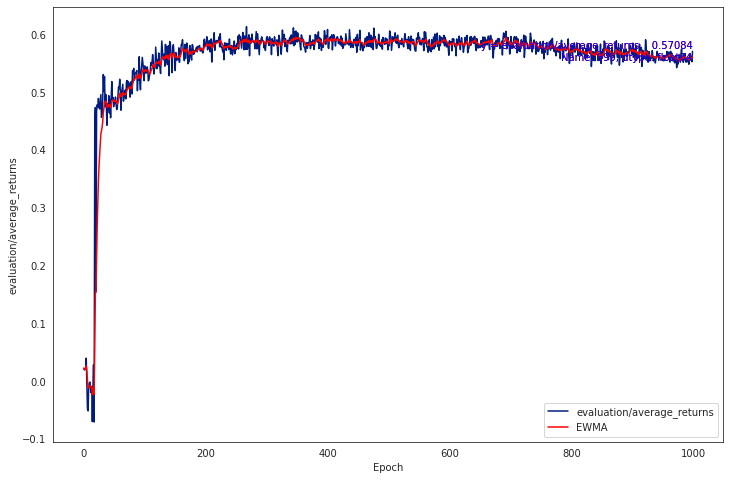

In [68]:
import wandb

import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
# white, dark, whitegrid, darkgrid, ticks
sns.set_style("white")
sns.set_palette( sns.color_palette('dark'))

api = wandb.Api()

def get_wandb_metric(name,entity="aimrl",project="MASTER_UNCERTAINTY",metric=r"evaluation/average_returns", epochs=1000):
    '''Get the data from a wandb run. Data is only a sample of 500 data from the run.
    
    Returns: metrics, config
    '''
    # name = 3pe2wl12"
    # run is specified by <entity>/<project>/<run_id>
    run = api.run(f"{entity}/{project}/{name}")

    # save the metrics for the run to a csv file
    metrics_dataframe = run.history(samples=epochs,x_axis=r"misc/epoch", keys=[metric,])
    config = run.config
    run.wait_until_finished()

    metrics_dataframe.set_index(r"misc/epoch",inplace=True)
    metrics_dataframe.sort_index(inplace=True)
    return metrics_dataframe,config

NAME = "31eeemjm"
METRIC = r"evaluation/average_returns"
NORMALIZE = True
metrics,config = get_wandb_metric(NAME, metric = METRIC)


if NORMALIZE:
    MIN_SCORE =REF_MIN_SCORE[config["env_name"]]
    MAX_SCORE =REF_MAX_SCORE[config["env_name"]]
    metrics = metrics.apply(lambda x: (x-MIN_SCORE)/(MAX_SCORE-MIN_SCORE), axis=0)
# metrics.plot()
# metrics.ewm(alpha=0.2).mean().plot(style="r")

# Compute EWMA of the metrics (Yt = α * Xt + (1 - α) * Y(t-1))
metrics_ewma = metrics.ewm(alpha=0.2).mean()

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the metrics and EWMA on the same axis
ax.plot(metrics.index, metrics, label=METRIC)
ax.plot(metrics_ewma.index, metrics_ewma, label='EWMA', color='r')

# Add legend and axis labels
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel(METRIC)

# Add text to the plot lines
y_value = metrics.iloc[-1]
ax.text(metrics.index[-1], y_value, f'y = {y_value}', ha='right', va='center', color='r')
ax.text(metrics_ewma.index[-1], y_value, f'y = {y_value}', ha='right', va='center', color='b')


# Display the plot
plt.show()



In [65]:
metrics.to_csv(f"{NAME}.csv")
config


{'seed': 0,
 'prefix': 'RORL_BASELINE_CONFIG_MIMIC_ADAPTIVE',
 'load_Qs': '',
 'env_name': 'halfcheetah-medium-v2',
 'algorithm': '',
 'load_path': '',
 'env_kwargs': {},
 'norm_input': True,
 'reward_std': False,
 'eval_attack': False,
 'reward_mean': False,
 'policy_kwargs': {'layer_size': 256, 'num_p_layers': 3, 'num_q_layers': 3},
 'collector_type': 'step',
 'offline_kwargs': {'batch_size': 128,
  'num_epochs': 0,
  'max_path_length': 1000,
  'save_snapshot_freq': 500,
  'num_eval_steps_per_epoch': 1000,
  'num_trains_per_train_loop': 1000},
 'trainer_kwargs': {'eta': -1,
  'qf_lr': 0.0003,
  'num_qs': 8,
  'discount': 0.99,
  'policy_lr': 0.0003,
  'q_ood_eps': 0.03,
  'q_ood_reg': 0.9,
  'num_samples': 10,
  'max_q_backup': False,
  'q_smooth_eps': 0.001,
  'q_smooth_reg': 0,
  'q_smooth_tau': 0.2,
  'soft_target_tau': 0.005,
  'policy_eval_start': 0,
  'policy_smooth_eps': 0.1,
  'policy_smooth_reg': 0,
  'deterministic_backup': False,
  'target_update_period': 1,
  'q_ood_uncer